# Pulse Benchmark - Evaluation
---
Calculates all metrics for task dataset combinations and prompt approaches from Metadata Files.
Creates heatmap for all combinations.

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import ast
import re

sys.path.append(r"C:\Users\janbe\Documents\GitHub Repos\pulse")
from src.eval.llm_analyzer import LLMAnalyzer, ModelAnalyzer
from src.eval.pulse_score import PULSEScoreCalculator

# Configuration and setup
import warnings

warnings.filterwarnings("ignore")

In [2]:
VARIABLE_NAMES = {
    "model_name": "Model Name",
    "task_id": "Task ID",
    "task": "Task",
    "dataset": "Dataset",
    "timestamp": "Timestamp",
    "model_id": "Model ID",
    "prompting_id": "Prompting ID",
    "sarvari_2024_aggregation_preprocessor": "Aggregation",
    "zhu_2024b_zero_shot_preprocessor": "Zero-shot",
    "liu_2023_few_shot_preprocessor": "Few-shot",
    "zhu_2024b_one_shot_preprocessor": "One-shot",
    "zhu_2024a_cot_preprocessor": "Chain-of-Thought",
    "zhu_2024c_categorization_summary_agent_preprocessor": "Categorization Summary Agent",
    "categorization_summary_agent_preprocessor": "Categorization Summary Agent",
    "aki": "AKI",
    "mortality": "Mortality",
    "sepsis": "Sepsis",
    "eicu": "eICU",
    "miiv": "MIMIC-IV",
    "hirid": "HiRID",
    "deepseekr1llama8b": "DeepSeek-R1 (Llama-8B)",
    "gemini2p5flash": "Gemini 2.5 Flash",
    "gemini2p5pro": "Gemini 2.5 Pro",
    "gemma3": "Gemma 3 4B",
    "gpt4o": "GPT-4o",
    "llama3p18b": "Llama 3 8B",
    "medgemma": "MedGemma 4B",
    "mistral7b": "Mistral 7B",
    "claudesonnet4": "Claude Sonnet 4",
    "o3": "OpenAI o3",
    "grok4": "Grok 4",
    "hybrid_reasoning_agent_preprocessor": "Hybrid Reasoning Agent",
    "collaborative_reasoning_agent_preprocessor": "Collaborative Reasoning Agent",
    "clinical_workflow_agent_preprocessor": "Clinical Workflow Agent",
    "pulse_score": "PULSE",
    "auroc": "AUROC",
    "auprc": "AUPRC",
}

In [3]:
# Set up directories
base_dir = r"C:\Users\janbe\Documents\GitHub Repos\pulse"
results_dir = os.path.join(base_dir, "output_to_keep", "results_benchmark")

#### Conventional Models

In [4]:
results_output_jsons = r"C:\Users\janbe\Documents\GitHub Repos\pulse\output_to_keep\results_benchmark\results_output\jsons"
result_dict = {}

In [5]:
model_list = os.listdir(results_dir)
for model in model_list:
    if model == "llms" or model == "results_output":
        continue


    print(f"Processing {model}...")
    cat_files = ModelAnalyzer.categorize_files(
        [os.path.join(results_dir, model)],
        verbose=False,
    )

    df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"])
    df_mdata = ModelAnalyzer.expand_full_dataset(df_mdata)

    # Strip "Model" from model_name and save as model_id
    df_mdata["model_id"] = (
        df_mdata["model_name"].str.replace("Model", "", regex=False).str.strip()
    )
    model_id = df_mdata["model_id"].unique()[0]
    result_dict[model_id] = {"score": None, "mdata": df_mdata}

Processing 20250603_160304_CNN...
Extracting metadata from files:

Processing 20250603_192812_GRU...
Extracting metadata from files:

Processing 20250604_094650_LSTM...
Extracting metadata from files:

Processing 20250617_131406_InceptionTime...
Extracting metadata from files:

Processing 20250618_192129_XGBoost...
Extracting metadata from files:

Processing 20250619_004541_RandomForest...
Extracting metadata from files:

Processing 20250619_005217_LightGBM...
Extracting metadata from files:



In [6]:
# Calculate PULSE scores for each model
psc = PULSEScoreCalculator(
    is_llm_model=False
)  # Specify this is for classical ML models

for model, data in result_dict.items():
    print("========================================")
    print(f"Calculating PULSE score for {model}...")
    df_mdata = data["mdata"]
    if df_mdata.empty:
        continue

    # First prepare the data to map columns to PULSE format
    df_prepared = psc.prepare_dataframe_for_pulse(
        df=df_mdata,
        target_col_candidates=["label_value"],
        prob_col_candidates=["probability"],
        pred_col_candidates=["binary_prediction"],
        task_col_candidates=["task"],
        dataset_col_candidates=["dataset"],
        verbose=True,  # This will show the verification report
    )

    # Now calculate the PULSE score using the prepared data
    score = psc.calculate_pulse_score_from_dataframe(
        df=df_prepared,
        target_col="Target Label",
        prob_col="Predicted Probability",
        pred_col=None,  # Auto-detect the prediction column
        task_col="task",
        dataset_col="dataset",
    )
    score["prompting_id"] = ""  # empty for convModels
    score["model_id"] = model
    result_dict[model]["score"] = score

    # Save results as json. Uses pulse-result format
    json_output_path = os.path.join(results_output_jsons, f"{model}_results.json")
    LLMAnalyzer.save_results_dict_as_json({model: score}, json_output_path)

Calculating PULSE score for CNN...
Model Type: Conventional ML
✓ No invalid predictions detected
✅ Data format is correct for PULSE calculation!

Data distribution by task:

AKI:
  Total samples: 2950/2950
  Positive labels: 693
  Valid predictions: 2950
  Positive predictions: 787.0
  Probability range: [0.000, 1.000]
  Probability mean: 0.292
  Probability std: 0.328
  Probability median: 0.140

MORTALITY:
  Total samples: 300/300
  Positive labels: 30
  Valid predictions: 300
  Positive predictions: 56.0
  Probability range: [0.000, 1.000]
  Probability mean: 0.178
  Probability std: 0.312
  Probability median: 0.003

SEPSIS:
  Total samples: 2939/2939
  Positive labels: 145
  Valid predictions: 2939
  Positive predictions: 73.0
  Probability range: [0.000, 0.999]
  Probability mean: 0.036
  Probability std: 0.143
  Probability median: 0.000

Data types and unique values:
  Target Label: int64, values: [0 1]
  binary_prediction: int64, values: [0 1]

Data source information:
  • Cla

#### LLMs

In [7]:
def calculate_cost_per_sample(df_mdata, input_cost, output_cost):
    """
    Calculate the cost per sample based on the model's metadata.
    """
    avg_input_tokens = df_mdata["Input Tokens"].mean()
    avg_output_tokens = df_mdata["Output Tokens"].mean()
    avg_reasoning_tokens = (
        df_mdata["Thinking Tokens"].mean()
        if "reasoning_tokens" in df_mdata.columns or "Thinking Tokens" in df_mdata.columns
        else 0
    )

    cost_per_sample = (
        avg_input_tokens * input_cost
        + avg_output_tokens * output_cost
        + avg_reasoning_tokens * output_cost
    ) / 10**6

    return cost_per_sample

In [8]:
llm_model_list = os.listdir(os.path.join(results_dir, "llms"))
cost_dict = {
    "OpenAI o3": {"input_cost": 2, "output_cost": 8},
    "GPT-4o": {"input_cost": 2.5, "output_cost": 10},
    "Gemini 2.5 Flash": {"input_cost": 0.3, "output_cost": 2.5},
    "Gemini 2.5 Pro": {"input_cost": 1.25, "output_cost": 10},
    "Claude Sonnet 4": {"input_cost": 3, "output_cost": 15},
    "Grok 4": {"input_cost": 3, "output_cost": 15},
}


for llm_model in llm_model_list:

    print("===================================================")

    print(f"Processing LLM model: {llm_model}...")
    json_output_path = os.path.join(results_output_jsons, f"{llm_model}_results.json")
    result_dict[llm_model] = {}


    save_dict = {}

    prompt_approaches = os.listdir(os.path.join(results_dir, "llms", llm_model))


    for prompt_approach in prompt_approaches:

        print(f"Processing {prompt_approach}...")

        cat_files = LLMAnalyzer.categorize_files(



            [os.path.join(results_dir, "llms", llm_model, prompt_approach)],



            verbose=False,



        )


        df_mdata = LLMAnalyzer.load_metadata(cat_files["metadata_files"])

        if "Step Name" in df_mdata.columns:

            df_mdata = df_mdata[df_mdata["Step Name"] == "final_prediction"]


        ps = PULSEScoreCalculator()

        pulse_score = ps.calculate_pulse_score_from_raw_data(
            df=df_mdata,



            show_detailed_report=True,




        )

        # Check if the model is in the cost_dict
        model_name = VARIABLE_NAMES.get(llm_model, llm_model)
        if model_name not in cost_dict:
            df_mdata["Cost_per_sample"] = 0.0

        else:
            df_mdata["Cost_per_sample"] = calculate_cost_per_sample(
                df_mdata,
                input_cost=cost_dict[model_name]["input_cost"],
                output_cost=cost_dict[model_name]["output_cost"],
            )

        result_dict[llm_model][prompt_approach] = {
                "score": pulse_score,
                "mdata": df_mdata,
        }


        pulse_score["model_id"] = llm_model

        pulse_score["prompting_id"] = prompt_approach

        save_dict[prompt_approach] = pulse_score

        print("--------------------------------------------")


    # Save results as json. Uses pulse-result format

    LLMAnalyzer.save_results_dict_as_json(



        save_dict, json_output_path



    )

Processing LLM model: claudesonnet4...
Processing hybrid_reasoning_agent_preprocessor...
Extracting metadata from files:

Preparing data for ClaudeSonnet4 PULSE score calculation...
Model Type: LLM
✓ No invalid predictions detected
✅ Data format is correct for PULSE calculation!

Data distribution by task:

AKI:
  Total samples: 2950/2950
  Positive labels: 693
  Valid predictions: 2950
  Positive predictions: 212.0
  Probability range: [0.020, 1.000]
  Probability mean: 0.171
  Probability std: 0.190
  Probability median: 0.100

MORTALITY:
  Total samples: 300/300
  Positive labels: 30
  Valid predictions: 300
  Positive predictions: 8.0
  Probability range: [0.020, 1.000]
  Probability mean: 0.093
  Probability std: 0.140
  Probability median: 0.050

SEPSIS:
  Total samples: 2939/2939
  Positive labels: 145
  Valid predictions: 2939
  Positive predictions: 17.0
  Probability range: [0.020, 0.960]
  Probability mean: 0.069
  Probability std: 0.065
  Probability median: 0.060

Data typ

In [9]:
# Create the DataFrame
results_df = LLMAnalyzer.create_results_dataframe_from_pulse_results(result_dict)
results_df

,model_id,prompting_approach,task_dataset_key,pulse_score,base_score,auroc,auprc,mcc_raw,mcc,normalized_auprc,...,minpse,ccf,avg_penalty,total_penalties,num_penalized,dataset,task_id,model_name,run_id,task
0,CNN,,aki_eicu,70.804113,0.708041,0.779584,0.625295,0.437830,0.718915,2.017344,...,0.594771,1.000000,0.000000,0.00,0,eicu,aki,CNNModel,20250605_113136,NaN
1,CNN,,aki_hirid,63.257130,0.632571,0.807324,0.418029,0.342382,0.671191,2.581787,...,0.447853,1.000000,0.000000,0.00,0,hirid,aki,CNNModel,20250605_113136,NaN
2,CNN,,aki_miiv,68.607830,0.686078,0.774302,0.600746,0.366544,0.683272,2.581370,...,0.510549,1.000000,0.000000,0.00,0,miiv,aki,CNNModel,20250605_113136,NaN
3,CNN,,mortality_eicu,66.282400,0.662824,0.844854,0.452002,0.381538,0.690769,6.457172,...,0.428571,1.000000,0.000000,0.00,0,eicu,mortality,CNNModel,20250605_113136,NaN
4,CNN,,mortality_hirid,72.685949,0.726859,0.843718,0.608406,0.456815,0.728407,5.530964,...,0.545455,1.000000,0.000000,0.00,0,hirid,mortality,CNNModel,20250605_113136,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706,o3,zhu_2024b_zero_shot_preprocessor,mortality_hirid,48.609313,0.490260,0.605209,0.289994,0.146137,0.573069,2.636305,...,0.333333,0.991500,0.008500,0.85,9,hirid,mortality,OpenAIo3,20250704_163021,mortality
707,o3,zhu_2024b_zero_shot_preprocessor,mortality_miiv,68.444150,0.686983,0.855587,0.467640,0.472462,0.736231,3.896998,...,0.583333,0.996300,0.003700,0.37,3,miiv,mortality,OpenAIo3,20250704_163021,mortality
708,o3,zhu_2024b_zero_shot_preprocessor,sepsis_eicu,38.994215,0.390600,0.572131,0.050936,0.088164,0.544082,1.062068,...,0.067616,0.998316,0.001684,1.65,26,eicu,sepsis,OpenAIo3,20250704_163021,sepsis
709,o3,zhu_2024b_zero_shot_preprocessor,sepsis_hirid,41.681063,0.417099,0.596051,0.192199,-0.076608,0.461696,2.551242,...,0.260274,0.999309,0.000691,0.67,11,hirid,sepsis,OpenAIo3,20250704_163021,sepsis


#### Plots

In [10]:
import seaborn as sns
def create_results_heatmap(df, score_column="pulse_score", figsize=(16, 10), save_path=None):
    """
    Creates a heatmap showing scores for task-dataset combinations versus model-prompting approach combinations.

    Args:
        df (pd.DataFrame): Input DataFrame containing results.
        score_column (str, optional): Column name for the score to plot. Defaults to "pulse_score".
        figsize (tuple, optional): Figure size for the plot. Defaults to (16, 10).
        save_path (str, optional): Path to save the figure. If None, the figure is not saved.

    Returns:
        pd.DataFrame: Pivoted matrix used for the heatmap.
    """
    # Make task-dataset combinations
    df_plot = df.copy()
    df_plot["task_dataset"] = (
        df_plot["task_id"].map(lambda x: VARIABLE_NAMES.get(x, x)).astype(str)
        + " - "
        + df_plot["dataset"].map(lambda x: VARIABLE_NAMES.get(x, x)).astype(str)
    )

    df_plot["model_clean"] = df_plot["model_id"].map(lambda x: VARIABLE_NAMES.get(x, x))
    df_plot["approach_clean"] = (
        df_plot["prompting_approach"]
        .fillna("")
        .map(lambda x: VARIABLE_NAMES.get(x, x) if x else "")
    )
    df_plot["model_approach"] = df_plot["model_clean"] + "|" + df_plot["approach_clean"]

    heatmap_range = {
        "vmin": 0,
        "vmax": 100,
    }  # Default range for pulse_score

    if score_column != "pulse_score":
        heatmap_range = {
            "vmin": 0,
            "vmax": 1,
        }

    # Pivot
    heatmap_data = df_plot.pivot_table(
        index="model_approach",
        columns="task_dataset",
        values=score_column,
        aggfunc="mean",
    )

    # Add Overall column (mean of all task-dataset combinations)
    heatmap_data["Overall"] = heatmap_data.mean(axis=1)

    # Sort heatmap_data by the Overall column in descending order
    heatmap_data = heatmap_data.sort_values(by="Overall", ascending=False)

    # Move Overall column to the end if not already
    cols = list(heatmap_data.columns)
    if "Overall" in cols:
        cols = [c for c in cols if c != "Overall"] + ["Overall"]
        heatmap_data = heatmap_data[cols]

    # Split model and approach for table
    labels_df = heatmap_data.index.to_frame(index=False)
    labels_df[["model", "approach"]] = labels_df["model_approach"].str.split(
        "|", expand=True
    )
    labels_df = labels_df.fillna("")

    matrix = heatmap_data.copy()

    # Make figure: give table more width
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        1, 2, width_ratios=[2.5, 4], wspace=-0.1
    )  # More room for table

    # Table axis (left)
    ax_table = fig.add_subplot(gs[0])
    ax_table.axis("off")

    # Heatmap axis (right)
    ax_heatmap = fig.add_subplot(gs[1])

    # Plot heatmap without y-ticks
    sns.heatmap(
        matrix,
        annot=True,
        fmt=".2f",  # Change to ".2f" for two decimal places, ".1f" for one, etc.
        cmap="RdYlBu_r",
        vmin=heatmap_range["vmin"],
        vmax=heatmap_range["vmax"],
        cbar_kws={"label": f"{VARIABLE_NAMES.get(score_column,score_column)} Score"},
        linewidths=0.5,
        linecolor="gray",
        ax=ax_heatmap,
    )

    ax_heatmap.set_yticks([])
    ax_heatmap.set_ylabel("")
    ax_heatmap.set_xlabel("Task - Dataset", fontsize=14, fontweight="bold")
    ax_heatmap.set_xticklabels(
        ax_heatmap.get_xticklabels(), rotation=45, ha="right", fontsize=12
    )

    # Adjust table text positions: more horizontal spacing
    x_model = 0.0
    x_approach = 2.7  # More space to prevent overlap
    num_rows = matrix.shape[0]

    ax_table.text(x_model, num_rows + 2, "Model", fontsize=14, ha="left")
    ax_table.text(
        x_approach,
        num_rows + 2,
        "Approach",
        fontsize=14,
        ha="left",
    )

    # Add custom labels and long horizontal lines
    last_model = None
    for i, (model, approach) in enumerate(
        zip(labels_df["model"], labels_df["approach"])
    ):
        y = i + 0.5  # Changed from: num_rows - i - 0.5

        ax_table.text(
            x_model,
            y,
            model,
            va="center",
            ha="left",
            fontsize=9,
        )
        ax_table.text(x_approach, y, approach, va="center", ha="left", fontsize=9)

        if i > 0: #and model != last_model and model != "Overall":
            # Draw hline in BOTH axes so it spans full width
            ax_table.hlines(
                y - 0.5, x_model, x_approach + 5, color="grey", linewidth=0.5
            )  # Changed from: y + 0.5
            ax_heatmap.hlines(
                y - 0.5, *ax_heatmap.get_xlim(), color="grey", linewidth=0.5
            )  # Changed from: y + 0.5

        last_model = model

    # Match y-limits
    ax_table.set_ylim(ax_heatmap.get_ylim())

    fig.suptitle(
        f"{VARIABLE_NAMES.get(score_column,score_column)} Scores: Task-Dataset Combinations vs Model-Prompting Approaches",
        fontsize=18,
        fontweight="bold",
        y=1.02,
    )

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)

    plt.show()

    return matrix

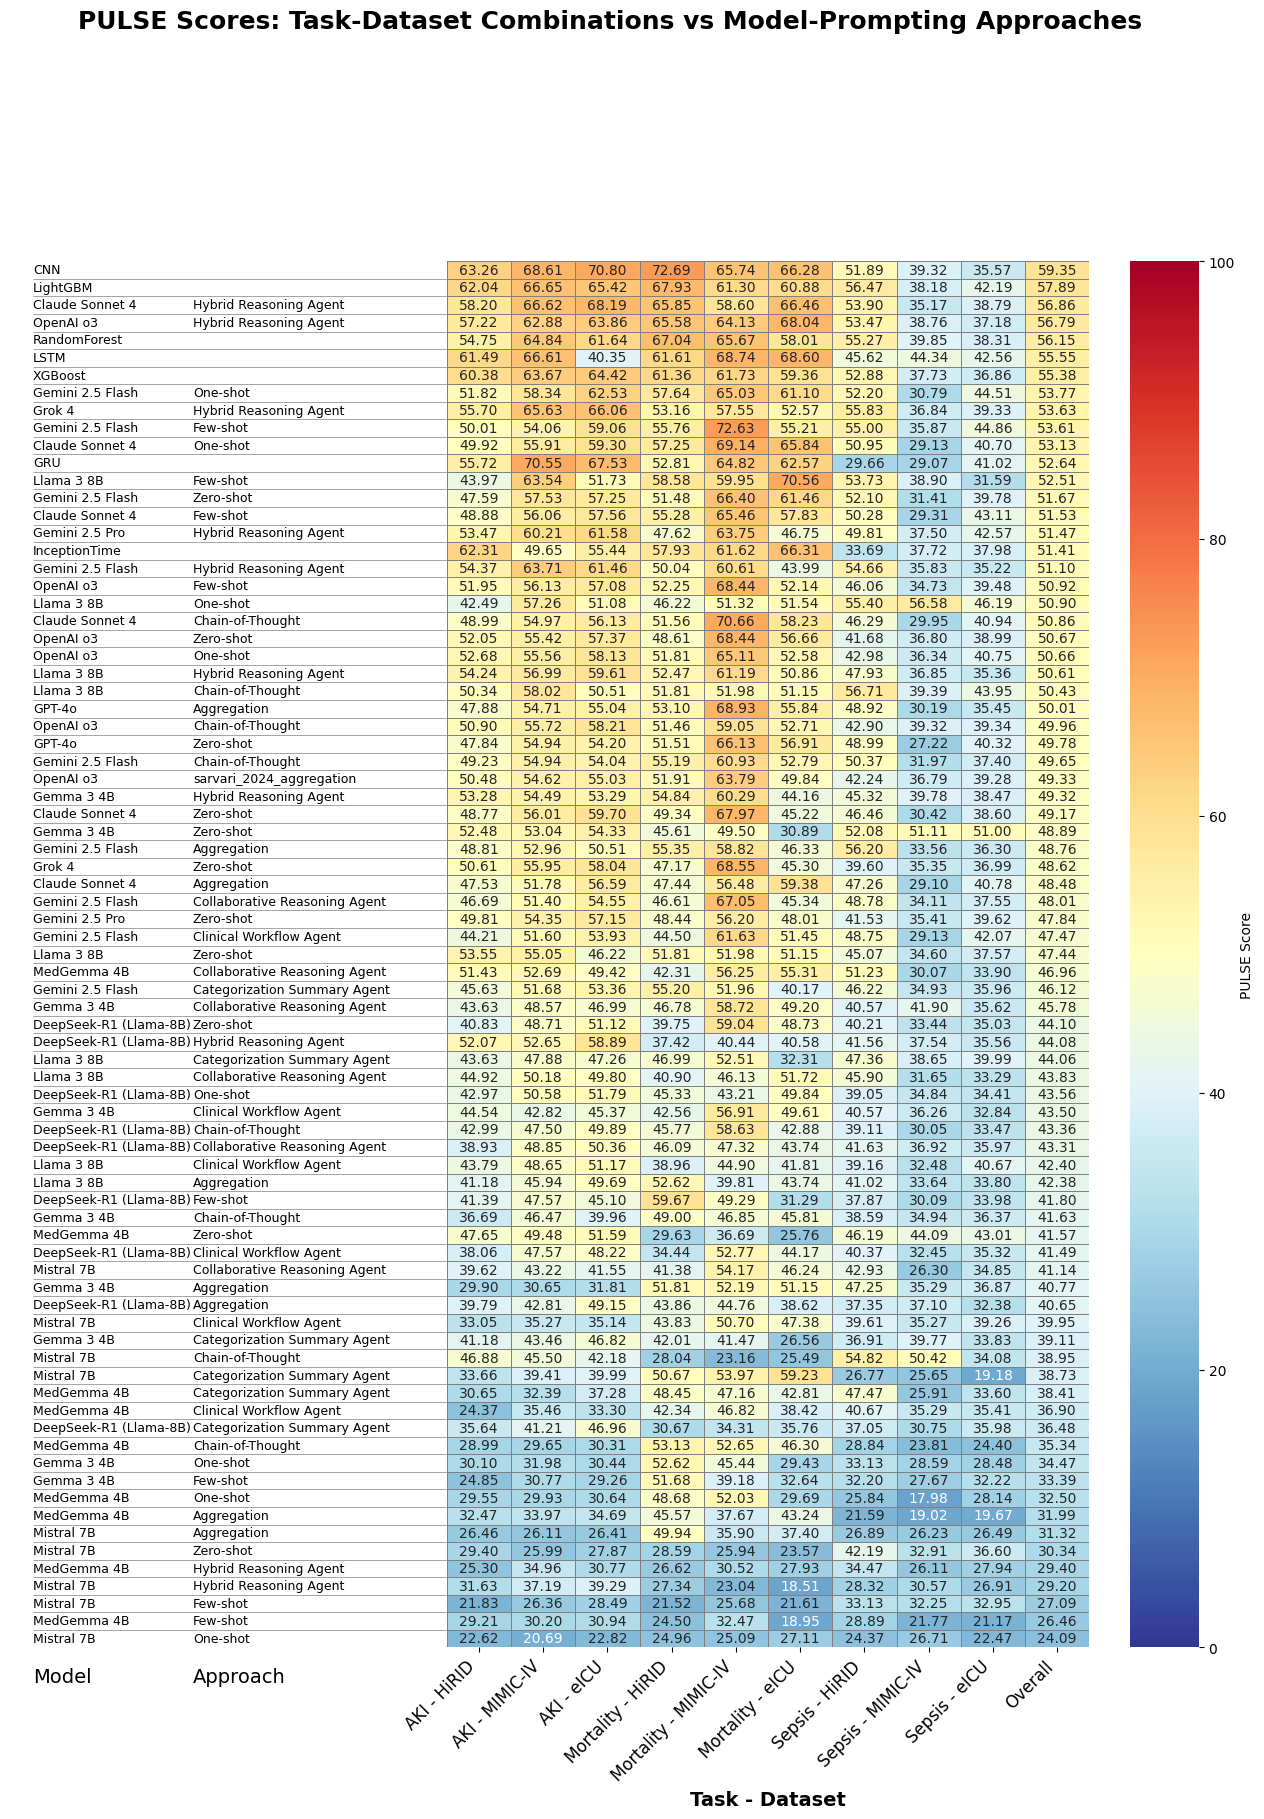

task_dataset,AKI - HiRID,AKI - MIMIC-IV,AKI - eICU,Mortality - HiRID,Mortality - MIMIC-IV,Mortality - eICU,Sepsis - HiRID,Sepsis - MIMIC-IV,Sepsis - eICU,Overall
model_approach,,,,,,,,,,
CNN|,63.257130,68.607830,70.804113,72.685949,65.741794,66.282400,51.890051,39.315536,35.567144,59.350216
LightGBM|,62.043970,66.647988,65.415954,67.927637,61.298748,60.881373,56.472412,38.178551,42.188305,57.894993
Claude Sonnet 4|Hybrid Reasoning Agent,58.195297,66.617618,68.186777,65.853515,58.599301,66.463247,53.898219,35.172455,38.793177,56.864401
OpenAI o3|Hybrid Reasoning Agent,57.222645,62.876948,63.858286,65.579572,64.128345,68.040789,53.470397,38.757892,37.181469,56.790705
RandomForest|,54.752651,64.842204,61.642307,67.035304,65.674144,58.010544,55.265715,39.845807,38.314868,56.153727
...,...,...,...,...,...,...,...,...,...,...
MedGemma 4B|Hybrid Reasoning Agent,25.295921,34.962449,30.769125,26.620122,30.522867,27.934928,34.467363,26.107718,27.936225,29.401857
Mistral 7B|Hybrid Reasoning Agent,31.629110,37.194374,39.285115,27.335708,23.038964,18.513462,28.317843,30.571323,26.911152,29.199672
Mistral 7B|Few-shot,21.828946,26.355356,28.492257,21.520259,25.676121,21.612984,33.125609,32.249533,32.948787,27.089984


In [11]:
create_results_heatmap(results_df, figsize=(16,18), save_path="plots/pulse_score_heatmap.png")

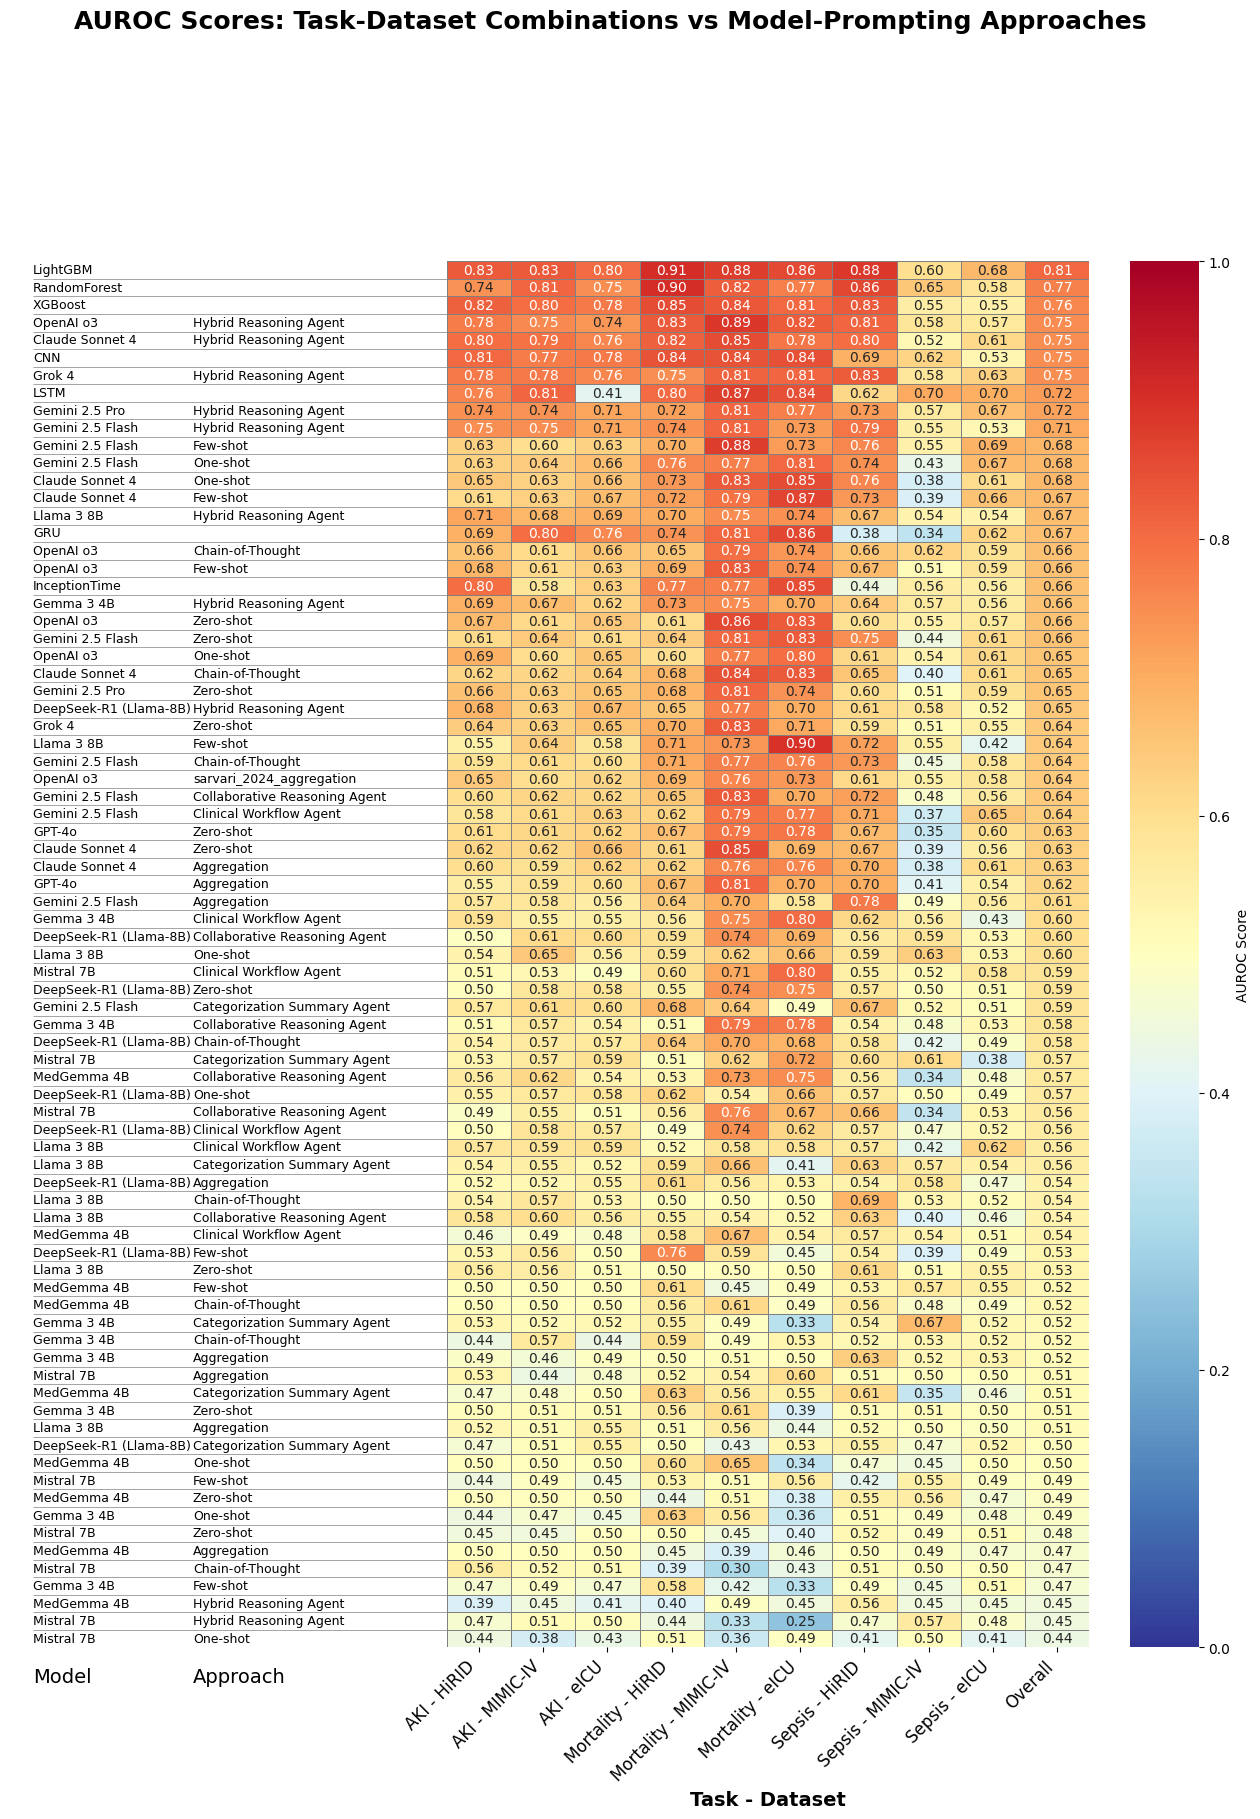

task_dataset,AKI - HiRID,AKI - MIMIC-IV,AKI - eICU,Mortality - HiRID,Mortality - MIMIC-IV,Mortality - eICU,Sepsis - HiRID,Sepsis - MIMIC-IV,Sepsis - eICU,Overall
model_approach,,,,,,,,,,
LightGBM|,0.829371,0.831551,0.801922,0.906027,0.878788,0.857143,0.883332,0.600000,0.676199,0.807148
RandomForest|,0.742096,0.811868,0.749105,0.902451,0.822917,0.773425,0.862349,0.652145,0.584377,0.766748
XGBoost|,0.816632,0.799141,0.779311,0.854954,0.835227,0.806452,0.829394,0.554881,0.545575,0.757952
OpenAI o3|Hybrid Reasoning Agent,0.775641,0.754085,0.737751,0.831461,0.889205,0.824885,0.812240,0.580249,0.571606,0.753013
Claude Sonnet 4|Hybrid Reasoning Agent,0.798578,0.791142,0.761455,0.819203,0.851799,0.781874,0.799207,0.522611,0.611970,0.748649
...,...,...,...,...,...,...,...,...,...,...
Mistral 7B|Chain-of-Thought,0.562335,0.517239,0.510160,0.394280,0.303504,0.430108,0.513699,0.500000,0.498928,0.470028
Gemma 3 4B|Few-shot,0.469444,0.488895,0.466643,0.582737,0.422822,0.325653,0.493112,0.448187,0.508814,0.467367
MedGemma 4B|Hybrid Reasoning Agent,0.389723,0.447063,0.412294,0.398366,0.492898,0.452381,0.555414,0.446301,0.454163,0.449845


In [12]:
create_results_heatmap(
    results_df,
    score_column="auroc",
    figsize=(16, 18),
    save_path="plots/auroc_score_heatmap.png",
)

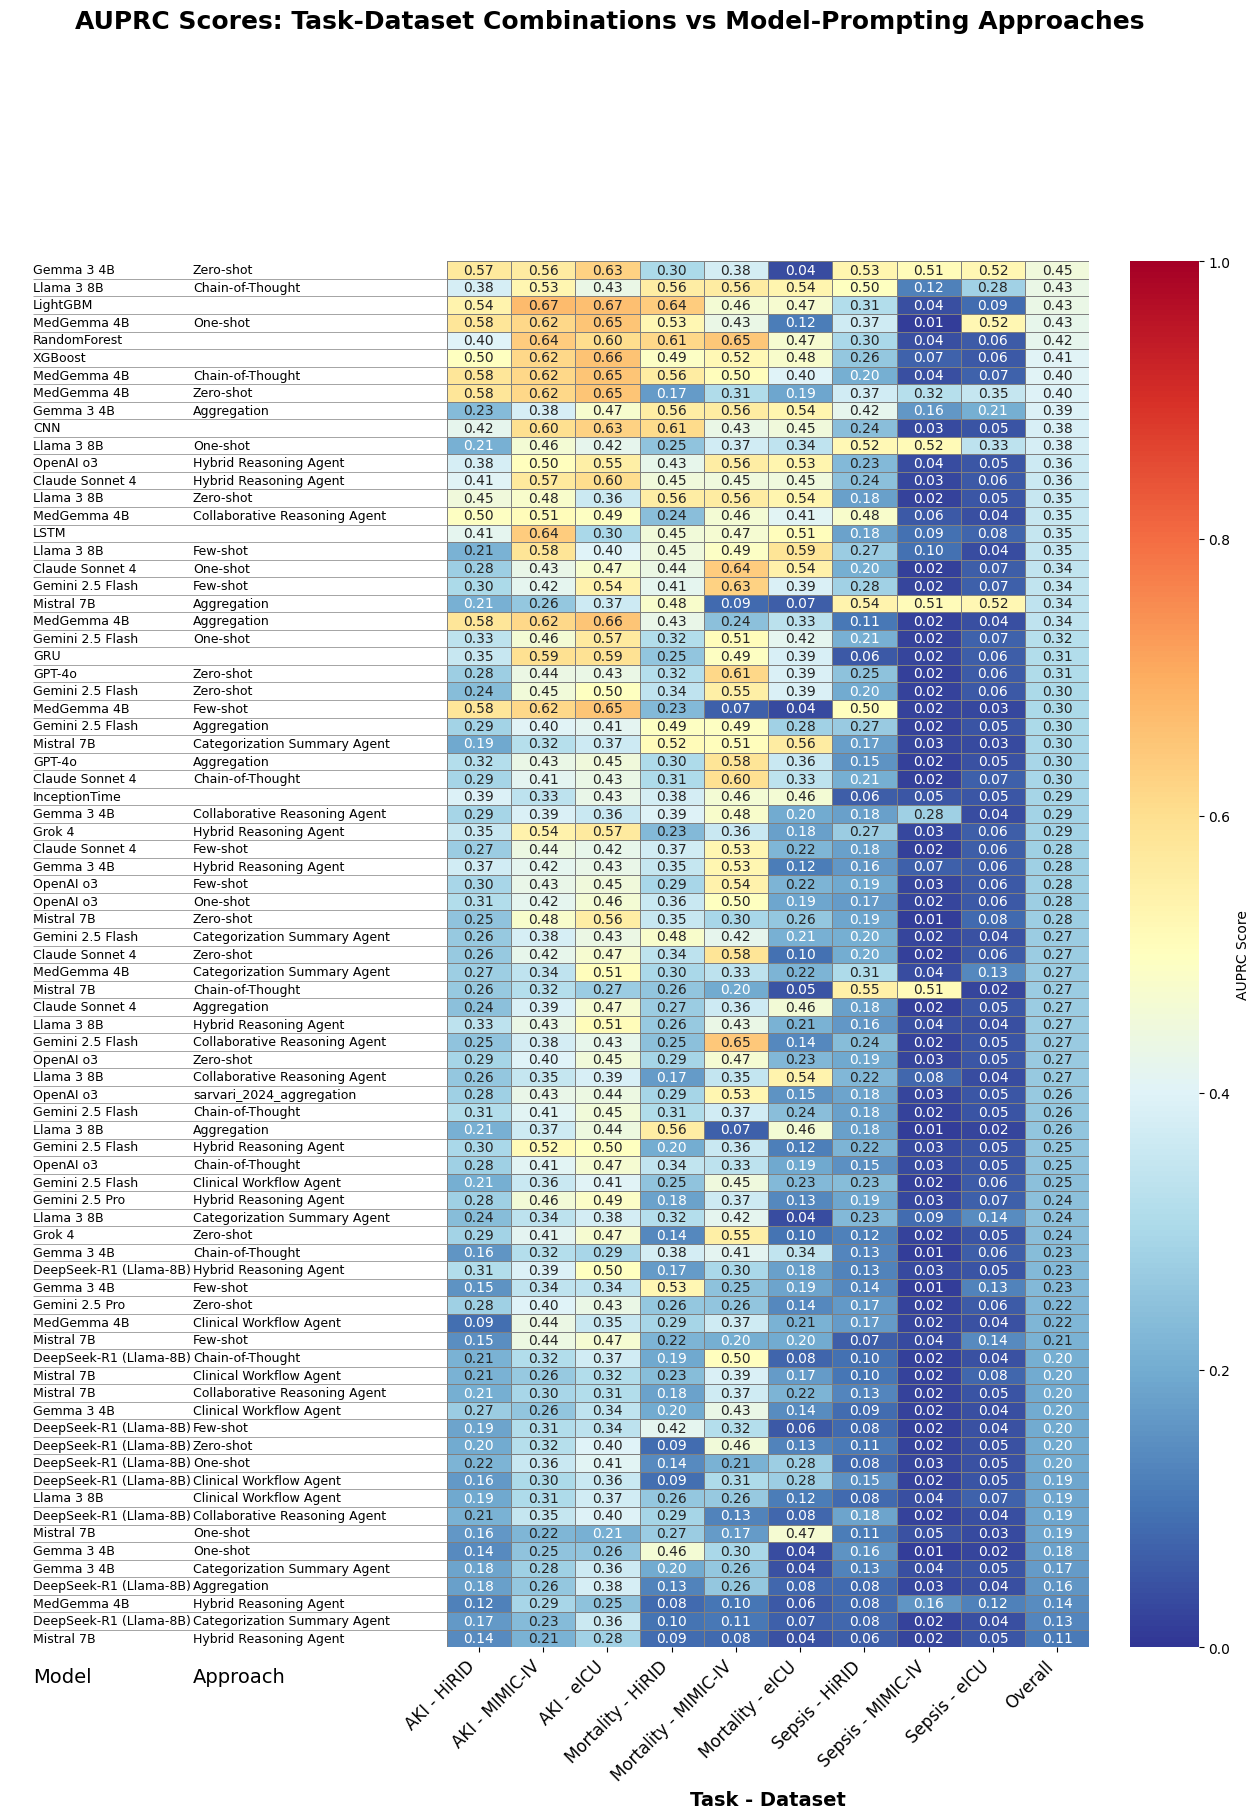

task_dataset,AKI - HiRID,AKI - MIMIC-IV,AKI - eICU,Mortality - HiRID,Mortality - MIMIC-IV,Mortality - eICU,Sepsis - HiRID,Sepsis - MIMIC-IV,Sepsis - eICU,Overall
model_approach,,,,,,,,,,
Gemma 3 4B|Zero-shot,0.573682,0.564879,0.627211,0.302032,0.376774,0.035303,0.532240,0.512913,0.524029,0.449896
Llama 3 8B|Chain-of-Thought,0.381384,0.529836,0.432839,0.555000,0.560000,0.535000,0.499090,0.123256,0.281970,0.433153
LightGBM|,0.535598,0.672934,0.665228,0.637235,0.463598,0.472596,0.312801,0.041774,0.087083,0.432094
MedGemma 4B|One-shot,0.580957,0.616362,0.654980,0.526959,0.430556,0.115075,0.369554,0.013282,0.524103,0.425759
RandomForest|,0.401923,0.637895,0.603692,0.613770,0.652057,0.469318,0.297218,0.040152,0.061528,0.419728
...,...,...,...,...,...,...,...,...,...,...
Gemma 3 4B|Categorization Summary Agent,0.184809,0.277768,0.364811,0.197538,0.260179,0.043077,0.126638,0.040062,0.048135,0.171446
DeepSeek-R1 (Llama-8B)|Aggregation,0.177572,0.260092,0.379295,0.126808,0.260734,0.079422,0.083020,0.028599,0.041073,0.159624
MedGemma 4B|Hybrid Reasoning Agent,0.124156,0.293941,0.247806,0.082793,0.102327,0.055467,0.083737,0.158938,0.123457,0.141402


In [13]:
create_results_heatmap(
    results_df,
    score_column="auprc",
    figsize=(16, 18),
    save_path="plots/auprc_score_heatmap.png",
)

In [14]:
def create_cost_performance_plot(result_dict, figsize=(12, 8), save_path=None):
    """
    Creates a scatter plot showing cost per sample vs PULSE score for LLM models.
    
    Args:
        result_dict (dict): Dictionary containing model results with cost and performance data
        figsize (tuple): Figure size for the plot
        save_path (str): Path to save the figure
    """
    plot_data = []
    
    # Extract data from result_dict for LLM models only
    for model_id, model_data in result_dict.items():
        if isinstance(model_data, dict) and 'score' in model_data and 'mdata' in model_data:
            # This is a conventional model, skip
            continue
            
        # This is an LLM model with multiple prompt approaches
        for approach, approach_data in model_data.items():
            if isinstance(approach_data, dict) and 'score' in approach_data and 'mdata' in approach_data:
                pulse_score = approach_data['score']['overall']['overall_score']
                
                # Get cost per sample from metadata
                df_mdata = approach_data['mdata']
                if 'Cost_per_sample' in df_mdata.columns:
                    avg_cost = df_mdata['Cost_per_sample'].mean()
                else:
                    avg_cost = 0
                
                # Convert cost from per million tokens to per sample (assuming it's already per sample)
                cost_per_sample = avg_cost # Convert to dollars per sample
                
                plot_data.append({
                    'model_id': model_id,
                    'approach': approach,
                    'pulse_score': pulse_score,
                    'cost_per_sample': cost_per_sample,
                    'model_approach': f"{VARIABLE_NAMES.get(model_id, model_id)}",
                    'approach_clean': VARIABLE_NAMES.get(approach, approach)
                })
    
    df_plot = pd.DataFrame(plot_data)
    
    if df_plot.empty:
        print("No data found for cost-performance plot")
        return
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Color map for different models
    models = df_plot['model_id'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))
    color_map = dict(zip(models, colors))
    
    # Markers for different approaches
    approaches = df_plot['approach'].unique()
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'H', '+', 'x']
    marker_map = dict(zip(approaches, markers[:len(approaches)]))
    
    # Plot each point
    for _, row in df_plot.iterrows():
        plt.scatter(
            row['cost_per_sample'], 
            row['pulse_score'],
            c=[color_map[row['model_id']]],
            marker=marker_map[row['approach']],
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5,
            label=f"{row['model_approach']} - {row['approach_clean']}"
        )
    
    # Customize the plot
    plt.xlabel('Inference cost per sample ($)', fontsize=12)
    plt.ylabel('PULSE Score', fontsize=12)
    plt.title('PULSE Performance-Cost Frontier', fontsize=16)
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Add legend with two columns - one for models, one for approaches
    # Create custom legend
    model_handles = [plt.scatter([], [], c=[color_map[model]], marker='o', s=100, 
                                label=VARIABLE_NAMES.get(model, model)) for model in models]
    approach_handles = [plt.scatter([], [], c='gray', marker=marker_map[approach], s=100,
                                   label=VARIABLE_NAMES.get(approach, approach)) for approach in approaches]
    
    # Create two legends inside the plot grid
    # Place legends side by side at the bottom
    # Place legends side by side at the bottom right inside the plot
    model_legend = plt.legend(handles=model_handles, title='Models',
                             loc='lower right', bbox_to_anchor=(1.0, 0.01), frameon=True)
    plt.gca().add_artist(model_legend)

    approach_legend = plt.legend(handles=approach_handles, title='Approaches',
                                loc='lower right', bbox_to_anchor=(0.65, 0.01), frameon=True)
    
    plt.tight_layout()
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()
    
    return df_plot

In [15]:
result_dict["gemini2p5pro"]['zhu_2024b_zero_shot_preprocessor']['mdata']

,Input Prompt,Target Label,Predicted Probability,Predicted Diagnosis,Predicted Explanation,Tokenization Time,Inference Time,Input Tokens,Output Tokens,Thinking Tokens,Thinking Output,model_name,task,dataset,timestamp,Cost_per_sample
0,You are an experienced doctor in Intensive Car...,0,0.15,not-aki,Kidney function is currently stable. Serum cre...,0.0,20.805293,3942,107,1662,"Alright, let's get to work. I've got the patie...",Gemini2p5pro,aki,eicu,20250731_182349,0.024841
1,You are an experienced doctor in Intensive Car...,0,0.15,not-aki,Kidney function is currently stable. Serum cre...,0.0,23.111562,3943,108,1715,"Okay, here's what I'm thinking, breaking it do...",Gemini2p5pro,aki,eicu,20250731_182349,0.024841
2,You are an experienced doctor in Intensive Car...,0,0.20,not-aki,Kidney function is currently stable. Serum cre...,0.0,22.860653,3943,114,1773,"Alright, let's break this down. The task is to...",Gemini2p5pro,aki,eicu,20250731_182349,0.024841
3,You are an experienced doctor in Intensive Car...,0,0.95,aki,Acute kidney injury is diagnosed based on KDIG...,0.0,15.387086,3941,134,1257,"Alright, I've got the data, and I need to dete...",Gemini2p5pro,aki,eicu,20250731_182349,0.024841
4,You are an experienced doctor in Intensive Car...,0,0.95,aki,The patient meets KDIGO Stage 1 criteria for A...,0.0,24.964226,3941,120,2043,"Alright, let's analyze this ICU data. I've got...",Gemini2p5pro,aki,eicu,20250731_182349,0.024841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6184,You are an experienced doctor in Intensive Car...,1,0.85,sepsis,Patient meets Sepsis-3 criteria. The SOFA scor...,0.0,18.575128,3963,126,1812,"Alright, let's dissect this. The task is to de...",Gemini2p5pro,sepsis,miiv,20250731_182349,0.024841
6185,You are an experienced doctor in Intensive Car...,1,0.95,sepsis,Patient meets Sepsis-3 criteria. There is stro...,0.0,21.209333,3963,127,1858,"Alright, let's get to work. I'm being asked to...",Gemini2p5pro,sepsis,miiv,20250731_182349,0.024841
6186,You are an experienced doctor in Intensive Car...,1,0.90,sepsis,Patient meets Sepsis-3 criteria. There is stro...,0.0,22.322495,3963,135,1714,"Alright, let's get to work. I'm being asked to...",Gemini2p5pro,sepsis,miiv,20250731_182349,0.024841
6187,You are an experienced doctor in Intensive Car...,1,0.78,sepsis,Patient meets Sepsis-3 criteria with a SOFA sc...,0.0,24.970041,3963,105,2476,"Alright, let's get to work. The user wants me ...",Gemini2p5pro,sepsis,miiv,20250731_182349,0.024841


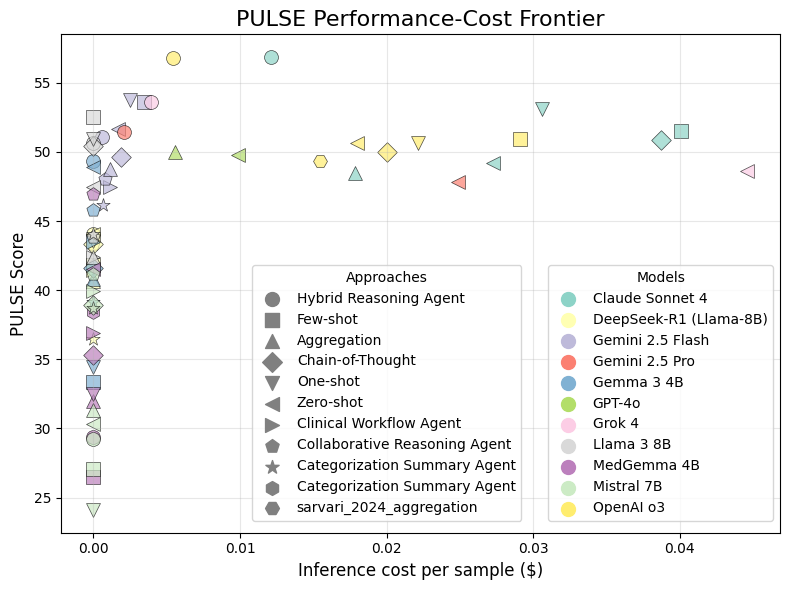

In [16]:
# Create cost vs performance plot
cost_perf_data = create_cost_performance_plot(
    result_dict, 
    figsize=(8, 6), 
    save_path="plots/pulse_cost_performance_frontier.png"
)